In [ ]:
# If loading new data
NGROK_URL = "8.tcp.ngrok.io:15447"
DATA_FILE = "ev21"
DATA_PATH = f'/content/drive/MyDrive/dc/{DATA_FILE}'

# Setup



Mounts google drive for persistent storage

In [ ]:
from google.colab import drive
from os import mkdir
from pathlib import Path


drive.mount('/content/drive')
Path('/content/drive/MyDrive/dc').mkdir(exist_ok=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm.notebook import tqdm
import itertools
import collections
import functools
from datetime import datetime
from sklearn.preprocessing import normalize

%matplotlib inline

Loads from file, falls back to loading from postgres server

In [ ]:
try:
  evidence = pd.read_feather(DATA_PATH + '.feather')
except FileNotFoundError:
  db = create_engine(f"postgresql://postgres:password@{NGROK_URL}/debate-cards").connect()
  query = """
    SELECT evidence.id, evidence."fileId", evidence.pocket, evidence.hat, evidence.block, evidence.tag, evidence.fullcite, evidence.cite, evidence."bucketId", evidence.markup
    FROM public."Evidence" evidence
      INNER JOIN public."_FileToTag" ftt ON evidence."fileId" = ftt."A"
      INNER JOIN public."Tag" tag on ftt."B" = tag.id
    WHERE tag.name='2021';
  """
  evidence = pd.read_sql(query, db)
  evidence.to_feather(DATA_PATH + '.feather')

In [ ]:
try:
  files = pd.read_feather(DATA_PATH + '_files.feather')
except FileNotFoundError:
  db = create_engine(f"postgresql://postgres:password@{NGROK_URL}/debate-cards").connect()
  query = """
    SELECT f.*
    FROM public."File" f
      INNER JOIN public."_FileToTag" ftt ON f.id = ftt."A"
      INNER JOIN public."Tag" tag on ftt."B" = tag.id
    WHERE tag.name='2021';
  """
  files = pd.read_sql(query, db)
  files.to_feather(DATA_PATH + '_files.feather')

Creates various useful transformations of data

In [ ]:
evClean = evidence.dropna(subset=['bucketId']).drop(columns='Unnamed: 0').fillna('')
buckets = evClean['bucketId'].drop_duplicates().reset_index(drop=True)
bucketIndexes = pd.Series(buckets.index.values, index=buckets)
fileIds = files['id'].reset_index(drop=True)
fClean = files.set_index('id')

Util function to display cards next to eachother

In [ ]:
def showCards(cards):
  divs = "\n".join([f"<div style='padding: 10px; flex: 1 1 0; overflow: scroll;'>{card.markup}</div>" for card in cards])
  display(HTML(f"<div style='display: flex; height: 1000px'>{divs}</div>"))

def showBucketSeries(series, indexes=range(5), iloc=0):
  showCards([evClean[evClean['bucketId'] == buckets[series.index[i]]].iloc[iloc] for i in indexes])

Util functions for generating graph

I think replace with $M^TM$ where M is matrix where $M_{ij}$ is 1 if block $i$ has card with bucketId $j$

In [ ]:

@functools.lru_cache(maxsize=1)
def genEdges():
  edges = {}
  for name, group in tqdm(evClean.groupby(['fileId', 'pocket', 'hat', 'block'])):
    for edge in itertools.combinations(bucketIndexes[group['bucketId']], 2):
      edges[edge] = edges.get(edge, 0) + 1
  return edges

# def genNormalizedEdges():
#   edgesNormalized = {}
#   print('Generating edges')
#   for name, group in tqdm(evClean.groupby(['fileId', 'pocket', 'hat', 'block'])):
#     for edge in itertools.permutations(bucketIndexes[group['bucketId']], 2):
#       edgesNormalized[edge] = edgesNormalized.get(edge, 0) + 1

#   print('Normalizing (~1 minute)')
#   edgesSeries = pd.Series(edgesNormalized)
#   edgesSeries.index = edgesSeries.index.set_names(['src', 'dest'])
#   return edgesSeries.groupby('src').transform(lambda x: x / x.sum())


Test cards

In [ ]:
frBuckets = (evClean[evClean['tag'].str.contains('fracking')]).groupby('bucketId').size().sort_values(ascending=False)
frBIndex = frBuckets.index[0]
frI = bucketIndexes[frBIndex]

teBuckets = (evClean[evClean['cite'].str.contains('teodoro', case=False)]).groupby('bucketId').size().sort_values(ascending=False)
teBIndex = teBuckets.index[1]
teI = bucketIndexes[teBIndex]

In [ ]:
evidence

,Unnamed: 0,id,fileId,pocket,hat,block,tag,fullcite,cite,bucketId,markup
0,0,798530,11437,Disclosure---Kentucky---Round 4,1NC,OFF,Maintains incentives for innovation,"Dagen 10 – Special Counsel to the Director, Bu...",Dagen 10,428979.0,<h4>Maintains incentives for innovation</h4><p...
1,1,475794,5631,Aff Answers vs. Fish CPs,Marine Protected Areas (MPAs) CP Answers,1AR — Doesn’t Solve,MPAs are not a panacea for ocean health.,"Margaret Cooney, 2019 (campaign manager for Oc...","Cooney, 2019",312715.0,<h4>MPAs are not a panacea for ocean health.</...
2,2,475827,5580,None,Psychoanalysis,Link—Warming,Unconscious desires is the root cause for clim...,"Sally Weintrobe on Michale Rustin, 09-24-2012,...","Weintrobe on Rustin, 12",316375.0,<h4>Unconscious desires is the <u>root cause</...
3,3,475814,5630,A2: Offcase,A2: Congress CP,2AC --- A2: Congress CP,--- Only the aff redefines the role of judicia...,"GUINIER 09 --- LANI GUINIER, Bennett Boskey Pr...","GUINIER 09 --- LANI GUINIER, Bennett Boskey Pr...",316311.0,<h4>--- Only the aff redefines the role of jud...
4,4,475831,5631,Aff Answers vs. Fish CPs,Magnuson-Stevens Act (MSA) Amendment CP,2AC — Magnusen-Stevens Act (MSA) Amendment CP ...,1. Doesn’t Solve Freshwater Fishing — that’s t...,"NOAA, No Date, The National Oceanic and Atmosp...","NOAA, No Date",316379.0,<h4>1. <u>Doesn’t Solve Freshwater Fishing</u>...
...,...,...,...,...,...,...,...,...,...,...,...
281793,281793,798553,11436,Disclosure---Kentucky---Round 6,1NC,Case,Military AI ushers in the erosion of conventio...,Brose ’19 – Senior Fellow at the Carnegie Endo...,Brose ’19,247480.0,<h4>Military AI ushers in the <u>erosion</u> o...
281794,281794,476357,5638,Politics Links,None,Political Capital Links,There are substantial political obstacles to t...,"BRUCE LIEBERMAN, 3/11/2021 (a long-time journa...",LIEBERMAN 21,312312.0,<h4>There are substantial political obstacles ...
281795,281795,476337,5638,Fishing Industry DA,None,AT: Subsidies/Bailouts Save the Fishing Industry,Subsidies can’t save the fishing industry:,"The Nippon Foundation, 3/14/2016 (“Ask an Expe...",The Nippon Foundation 16,312299.0,<h4><strong>Subsidies can’t save the fishing i...
281796,281796,476378,5637,Oceans Advantage,None,Oceans Key to Survival,Healthy oceans are key to life on Earth:,"Marine Conservation Institute, 2020 (Why Prote...","Marine Conservation Institute, 2020",314925.0,<h4>Healthy oceans are key to life on Earth:</...


In [ ]:
files

,id,createdAt,updatedAt,gid,name,path,status,roundId
0,5306,2022-08-19 16:38:14.886,2022-08-20 01:50:29.610,PLZDFW-G,States CP - Berkeley 2021,./documents/openev/2021/CNDI/States CP - Berke...,PROCESSED,NaN
1,5313,2022-08-19 16:38:15.853,2022-08-20 01:50:32.562,M5LFEBLZ,Fracking Aff Neg - Berkeley 2021,./documents/openev/2021/CNDI/Fracking Aff Neg ...,PROCESSED,NaN
2,5340,2022-08-19 16:38:16.660,2022-08-20 01:50:33.376,WJAHKQFY,WOTUS Case Neg - DDI 2021 AT,./documents/openev/2021/DDI/WOTUS Case Neg - D...,PROCESSED,NaN
3,5351,2022-08-19 16:38:16.989,2022-08-20 01:50:29.177,2Q67CP89,CBA Neg Updates - DDI 2021 HL,./documents/openev/2021/DDI/CBA Neg Updates - ...,PROCESSED,NaN
4,5376,2022-08-19 16:38:17.763,2022-08-20 01:50:41.632,SEMQSDT0,CBA Case Neg - DDI 2021 KM,./documents/openev/2021/DDI/CBA Case Neg - DDI...,PROCESSED,NaN
...,...,...,...,...,...,...,...,...
6909,17060,2022-08-27 16:16:14.756,2022-09-05 00:59:45.280,Q5JQFNF8,Lawrence%20Free%20State-Rupp-Marshall-Neg-02%2...,./documents/hspolicy21/LawrenceFreeState/RuMa/...,PROCESSED,20466.0
6910,17061,2022-08-27 16:16:26.774,2022-09-05 00:59:47.932,O7ZYH51E,Lawrence%20Free%20State-Rupp-Marshall-Neg-03%2...,./documents/hspolicy21/LawrenceFreeState/RuMa/...,PROCESSED,20463.0
6911,17062,2022-08-27 16:16:39.807,2022-09-05 00:59:48.529,UUW3WWUG,Lawrence%20Free%20State-Rupp-Marshall-Neg-02%2...,./documents/hspolicy21/LawrenceFreeState/RuMa/...,PROCESSED,20467.0
6912,17063,2022-08-27 16:16:51.838,2022-09-05 00:59:48.427,B39BNLVU,Lawrence%20Free%20State-Rupp-Marshall-Neg-03%2...,./documents/hspolicy21/LawrenceFreeState/RuMa/...,PROCESSED,20461.0


# Analysis


## Group sizes

In [ ]:
levels = ['fileId', 'pocket', 'hat', 'block']

In [ ]:
# def avgSiblings(sizes):
#   data = sizes.describe()
#   data['avgSiblings'] = (sizes ** 2).sum() / sizes.sum()
#   return data
def describeSiblings(groups):
  sizes = groups.size()
  return sizes.repeat(sizes).describe()

In [ ]:
levelSizes = pd.DataFrame({
    level: describeSiblings(evidence.groupby(levels[0:i+1])) for (i, level) in enumerate(levels)
})
levelSizes['bucket'] = describeSiblings(evidence.groupby('bucketId'))

In [ ]:
levelSizes

,fileId,pocket,hat,block,bucket
count,281798.000000,238716.000000,205751.000000,186665.000000,281130.000000
mean,63.934407,35.304152,15.885721,7.019093,30.314303
std,51.513433,33.406604,12.255007,6.452696,69.503753
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,35.000000,19.000000,7.000000,3.000000,1.000000
50%,54.000000,28.000000,13.000000,5.000000,6.000000
75%,70.000000,38.000000,23.000000,9.000000,26.000000
max,403.000000,325.000000,107.000000,50.000000,642.000000


In [ ]:
def plotGroupSizes(grouping):
  groupSizes = evidence.groupby(grouping).size().value_counts().sort_index()
  return plt.plot(groupSizes.index, groupSizes * groupSizes.index, label=grouping[-1])

(0.0, 200.0)

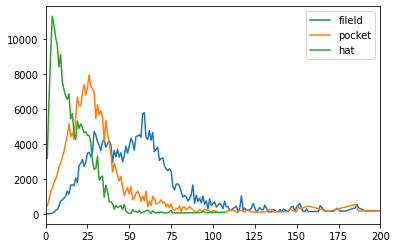

In [ ]:
plotGroupSizes(['fileId'])
plotGroupSizes(['fileId', 'pocket'])
plotGroupSizes(['fileId', 'pocket', 'hat'])
# plotGroupSizes(['fileId', 'pocket', 'hat', 'block'])
plt.legend()
plt.xlim(0, 200)

## Adjacency

### Build

In [ ]:
try:
  adjacency = sparse.load_npz(DATA_PATH + '.npz')
except FileNotFoundError:
  edges = genEdges()
  keys = np.array(list(edges.keys()))
  adjacency = sparse.lil_matrix((list(edges.values()), (keys[:, 0], keys[:, 1])), shape=(len(buckets), len(buckets)), dtype=np.int32)

  # Evidence should be a few times more related to itself than any other evidence, 3 specifically is arbitrary and could be changed
  diag = adjacency.max(axis=0).A[0] * 3
  # Fix evidence thats not related to anything
  diag[diag == 0] = 1
  adjacency.setdiag(diag)

  sparse.save_npz(DATA_PATH + '.npz', adjacency)
adjacencyN = normalize(adjacency, norm='l1', axis=0)
adjacencyN

<112310x112310 sparse matrix of type '<class 'numpy.float64'>'
	with 802564 stored elements in Compressed Sparse Column format>

In [ ]:
squaredN = adjacencyN ** 2

def listToVec(l, size):
  return sparse.csc_matrix(
      (np.ones(len(l)), (l, np.zeros(len(l), dtype=np.int32))),
      shape=(size, 1)
  )

def vecToSortedSeries(v):
  return pd.Series(index=v.tocoo().row, data=v.data).sort_values(ascending=False)

def getAdjacent(ids, iters=2, raw=False):
  v = listToVec(list(ids), adjacencyN.shape[0])
  if (iters % 2 == 1): v = adjacencyN @ v
  for i in range(iters // 2): v = squaredN @ v

  return v if raw else vecToSortedSeries(v)

### Misc

In [ ]:
sparse.linalg.eigs(adjacencyN)

(array([0.99986784+0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
        1.        +0.j, 1.        +0.j]),
 array([[-5.25683375e-19+0.j, -2.66556846e-18+0.j, -7.09520375e-18+0.j,
         -8.15135275e-20+0.j, -3.28549592e-18+0.j, -1.57553532e-18+0.j],
        [-1.10989693e-14+0.j,  5.60199292e-04+0.j,  3.00046987e-04+0.j,
          9.54805074e-05+0.j,  2.47840502e-03+0.j, -2.34989736e-04+0.j],
        [ 1.70308687e-13+0.j, -8.59937455e-03+0.j, -2.51899904e-03+0.j,
         -7.79796829e-03+0.j,  6.24228588e-03+0.j, -1.84700069e-03+0.j],
        ...,
        [ 7.01403007e-21+0.j,  1.04161455e-19+0.j,  3.81689134e-22+0.j,
         -4.66827561e-19+0.j,  1.91274393e-20+0.j, -2.41344112e-21+0.j],
        [ 2.12955618e-20+0.j, -1.36239298e-19+0.j,  3.69620386e-22+0.j,
          1.13635809e-18+0.j, -2.48905133e-20+0.j,  4.32436000e-21+0.j],
        [-4.72377602e-21+0.j,  2.53265444e-19+0.j, -8.63033359e-21+0.j,
         -2.29057260e-18+0.j,  5.96881593e-20+0.j, -9.77281684e-21+0.j]]))

In [ ]:
(adjacencyN[:, 1652][adjacencyN[:, 1652].todense() != 0])

matrix([[0.00552486, 0.05524862, 0.01104972, 0.01104972, 0.00552486,
         0.00552486, 0.26519337, 0.03867403, 0.00552486, 0.02762431,
         0.08839779, 0.03314917, 0.03867403, 0.03867403, 0.00552486,
         0.0441989 , 0.01104972, 0.02762431, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.01104972, 0.01657459, 0.00552486,
         0.00552486, 0.01657459, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.01104972, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486, 0.00552486, 0.00552486,
         0.00552486, 0.00552486, 0.00552486]])

In [ ]:
frBuckets = (evClean[evClean['tag'].str.contains('fracking')]).groupby('bucketId').size().sort_values(ascending=False)
frBIndex = frBuckets.index[0]
frI = bucketIndexes[frBIndex]
showBucketSeries(getAdjacent([frI], iters=1))
getAdjacent([frI], iters=1)

381      0.121101
539      0.040367
4058     0.038532
371      0.036697
7147     0.029358
           ...   
53672    0.001835
53668    0.001835
53163    0.001835
53123    0.001835
23446    0.001835
Length: 224, dtype: float64

In [ ]:
adjacent = getAdjacent([frI], iters=2)
showBucketSeries(adjacent, indexes=range(7))
adjacent

1652     0.030230
2563     0.029733
4058     0.026708
381      0.025906
10863    0.024082
           ...   
49877    0.000002
49850    0.000002
47966    0.000002
46942    0.000002
87569    0.000002
Length: 6042, dtype: float64

In [ ]:
teBuckets = (evClean[evClean['cite'].str.contains('teodoro', case=False)]).groupby('bucketId').size().sort_values(ascending=False)
teBIndex = teBuckets.index[1]
teI = bucketIndexes[teBIndex]
showBucketSeries(pd.Series(data=teBuckets.index, index=bucketIndexes[teBuckets.index].values))
teBuckets

bucketId
293018.0    7
293039.0    2
293620.0    2
305993.0    1
447073.0    1
308150.0    1
307959.0    1
307892.0    1
306729.0    1
306072.0    1
305986.0    1
293025.0    1
305981.0    1
293081.0    1
293075.0    1
293034.0    1
293029.0    1
447624.0    1
dtype: int64

In [ ]:
showBucketSeries(getAdjacent([teI]))
showBucketSeries(getAdjacent([teI], iters=3))
# evClean[evClean['bucketId'] == buckets[teI]].iloc[0].markup

In [ ]:
%timeit getAdjacent([frI])
%timeit getAdjacent([frI], iters=3)

1.64 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
8.99 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit getAdjacent([frI])
%timeit getAdjacent([frI], iters=3)

1.67 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.36 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
n_components, labels = sparse.csgraph.connected_components(adjacency)
n_components

15773

In [ ]:
def counts(arr):
  return np.asarray(np.unique(arr, return_counts=True)).T
counts(counts(labels)[:, 1])

'adjaceny'

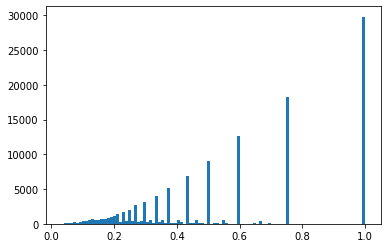

In [ ]:
vals = adjacencyN.max(axis=0).A[0]
plt.hist(vals[vals != 0], bins=100)
"adjaceny"

'adjaceny^2'

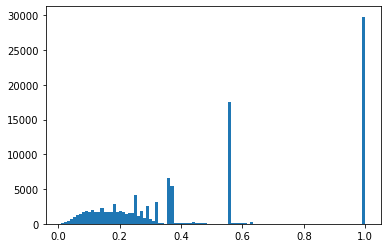

In [ ]:
vals = squaredN.max(axis=0).A[0]
plt.hist(vals[vals != 0], bins=100)
'adjaceny^2'

##### Inverse test

NOTE: Inverse calculation takes to long, probably will give bad results anyways because in higher powers individual entires are much smaller

Similarity = $∑_{n=1}^∞ α ^ {n-1} \cdot \text{Similarity from paths of length n}$

Where small values of $α \in [0, 1]$ give more importance to directly similar evidence, and larger values give more importance to globally important evidence

Similarity from paths of length n is the sum over all length n paths of the product of the weights

 this = $A^n$ where $A$ is the normalized adjacency matrix

Using the gemoetric series formula

Similarity = $(I - αA)^{-1}$

In [ ]:
alpha = 0.5

In [ ]:
adjustedAdjacency = (sparse.identity(adjacencyN.shape[0], format='csc') - alpha * adjacencyN)
adjustedAdjacency

<112310x112310 sparse matrix of type '<class 'numpy.float64'>'
	with 1407680 stored elements in Compressed Sparse Column format>

In [ ]:
# inverse = sparse.linalg.inv(adjustedAdjacency)
# inverse

In [ ]:
# sparse.save_npz('inverse', inverse)

### File

In [ ]:
# Example files
nwFile = 5361
frFile = 5480

In [ ]:
fileIndexes = pd.Series(fileIds.index, index=fileIds.values)
bucketFileMap = sparse.lil_matrix((len(fileIndexes), len(buckets)))

for fileId, group in tqdm(evClean.groupby('fileId')):
  bucketFileMap[fileIndexes[fileId], bucketIndexes[group['bucketId']]] = 1
bucketFileMap = bucketFileMap.tocsc()
bucketFileMap

  0%|          | 0/6733 [00:00<?, ?it/s]

<6914x112310 sparse matrix of type '<class 'numpy.float64'>'
	with 274631 stored elements in Compressed Sparse Column format>

In [ ]:
adjacentFiles = bucketFileMap @ adjacencyN @ bucketFileMap.T
adjacentFiles = normalize(adjacentFiles, norm='l1', axis=0)
adjacentFiles

<6914x6914 sparse matrix of type '<class 'numpy.float64'>'
	with 28040109 stored elements in Compressed Sparse Column format>

In [ ]:
sharedBucketFiles = bucketFileMap @ bucketFileMap.T
sharedBucketFiles

<6733x6733 sparse matrix of type '<class 'numpy.float64'>'
	with 4412195 stored elements in Compressed Sparse Column format>

In [ ]:
adjacentSFiles = bucketFileMap @ squaredN @ bucketFileMap.T
adjacentSFiles = normalize(adjacentSFiles, norm='l1', axis=0)
adjacentSFiles

<6914x6914 sparse matrix of type '<class 'numpy.float64'>'
	with 39110084 stored elements in Compressed Sparse Column format>

In [ ]:
evClean[evClean['fileId'] == 5361]

,id,fileId,pocket,hat,block,tag,fullcite,cite,bucketId,markup
29188,438028,5361,Aff – Tribal Water,1AC,1AC – Advantage,Discourses prioritizing existential threats ar...,"Mitchell 17 (Audra, a settler scholar who live...",Mitchell 17,3317.0,<h4>Discourses prioritizing <u>existential thr...
29367,438237,5361,Aff – Tribal Water,Case,Inh – AT: SQ Solves,"Specifically, federal agencies undermine triba...",Diver et al. 19 — research scientist at Stanfo...,Diver et al. 19,292196.0,"<h4>Specifically, federal agencies <u>undermin..."
231903,439399,5361,Aff – Tribal Water,AT: K,AT: K – Neolib – AT: RC,Race is a better predictor of tribal water ine...,"Tanana et al 21 (Heather Tanana (Lead Author),...",Tanana et al 21,292966.0,<h4>Race is a better predictor of tribal water...
232454,439758,5361,Neg – Tribal Water,T,T – Its,‘Its’ is possessive and refers to the party pr...,US District Court 7 United States District Cou...,US District Court 7,88617.0,<h4>‘Its’ is <u>possessive</u> and refers to t...
232469,439778,5361,Neg – Tribal Water,DA – Politics,L – Tribal Water,Tribal water bills are partisan,Grijalva 16 (Raúl Manuel Grijalva is U.S. Repr...,Grijalva 16,293174.0,<h4>Tribal water bills are <u>partisan</h4><p>...
...,...,...,...,...,...,...,...,...,...,...
250298,440784,5361,Neg – Tribal Water,K – Settlerism,L – Resource,Describing water as a resource to be managed r...,"Wilson and Inkster 20 (, "" Respecting water: I...",Wilson and Inkster 20,287598.0,<h4>Describing water as a resource to be manag...
250299,440824,5361,Neg – Tribal Water,K – Settlerism,L – Trust Responsibility Bad,The aff’s trust relationship model is paternal...,Diver 18 — research scientist at Stanford Univ...,Diver 18,293829.0,<h4>The aff’s trust relationship model is <u>p...
250312,440834,5361,Neg – Tribal Water,K – Settlerism,Alt – Water,The Alternative is indigenous led governance,"Wilson and Inkster 20 (, "" Respecting water: I...",Wilson and Inkster 20,287775.0,<h4>The Alternative is indigenous led governan...
266405,440527,5361,Neg – Tribal Water,CP – Tribes Alone,NB – Biodiversity,Empirics from controlled studies prove our arg...,"Doshi, ‘1-26 (Sahir Doshi is an RA researching...","Doshi, ‘1-26",292514.0,<h4><u>Empirics</u> from <u>controlled studies...


In [ ]:
def getRelatedFiles(fileId, squaredBucket=False):
  fileVec = listToVec([fileIndexes[fileId]], len(files))
  related = vecToSortedSeries((adjacentSFiles if squaredBucket else adjacentFiles) @ fileVec)
  return related.set_axis(fileIds[related.index])

In [ ]:
display(getRelatedFiles(nwFile, squaredBucket=False))
print()
display(getRelatedFiles(nwFile, squaredBucket=True))

id
5361     1.249882e-01
15142    6.318462e-02
16609    1.348533e-02
16666    7.965359e-03
14798    7.788692e-03
             ...     
15803    3.126336e-07
15805    3.126336e-07
13499    3.126336e-07
13745    3.126336e-07
12488    3.126336e-07
Length: 5774, dtype: float64

id
5361     1.125238e-01
15142    6.034276e-02
16609    1.158261e-02
14798    7.261511e-03
16666    7.057653e-03
             ...     
11836    2.382709e-09
13497    1.948021e-09
5391     9.229016e-10
5364     7.431657e-10
16096    7.081674e-10
Length: 6397, dtype: float64

In [ ]:
evClean[evClean['fileId'] == 16923]

,id,fileId,pocket,hat,block,tag,fullcite,cite,bucketId,markup
77900,874614,16923,,T,,1 - Predictable limits---they blur the lines t...,,,455956.0,<h4>1 - Predictable limits---they blur the lin...
84419,874638,16923,,K,,Neo-colonialism produces racialized sexualized...,Maldonado-Torres ‘08 associate professor of co...,Maldonado-Torres ‘08,2597.0,<h4>Neo-colonialism produces racialized sexual...
87737,874701,16923,,Framing,,Existential risks outweigh.,"Ord 20. Toby Ord, Senior Research Fellow in Ph...",Ord 20.,290980.0,<h4>Existential risks outweigh.</h4><p><strong...
87920,874758,16923,,Solvency,,Agencies will resist tribal self-governance tr...,Stommer and Osborne 15 - Geoffrey D. Strommer ...,Stommer and Osborne 15 -,297062.0,<h4>Agencies will resist tribal self-governanc...
223921,874611,16923,,T,,Vote neg:,,,455953.0,<h4>Vote neg:</h4>
223993,874602,16923,,T,,Interp: “In” means within the limits of,Webster’s 6 – Merriam Webster Online Dictionar...,Webster’s 6,128408.0,<h4>Interp: “In” means within the limits of</h...
224002,874635,16923,,K,,Colonial logic necessitates racialized violenc...,"Street ‘04 [Paul, writes on imperialism, racis...",Street ‘04,155685.0,<h4>Colonial logic necessitates racialized vio...
224007,874694,16923,,Framing,,We access all their framing through turns case...,,,455986.0,<h4>We access all their framing through <u>tur...
224017,874618,16923,,T,,2 - Topic education---core controversy is mean...,,,455959.0,<h4>2 - Topic education---core controversy is ...
224018,874627,16923,,T,,4 - Effects-T---They’re providing resources to...,,,455963.0,<h4>4 - Effects-T---They’re providing resource...


In [ ]:
getRelatedFiles(16609)

fileId
16609    3.314685e-02
5361     1.752779e-02
16666    1.163849e-02
5324     6.344629e-03
16923    5.097813e-03
             ...     
10635    3.931618e-07
11410    3.931618e-07
13121    3.931618e-07
12807    3.931618e-07
12308    3.931618e-07
Length: 5433, dtype: float64

In [ ]:
%timeit getRelatedFiles(nwFile)
%timeit getRelatedFiles(frFile)

2.22 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.6 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
getRelatedFiles(frFile)

fileId
5480     5.830518e-02
15538    6.528234e-03
15179    5.073391e-03
15334    4.769847e-03
15361    4.680265e-03
             ...     
13684    1.830149e-07
15118    1.830149e-07
11009    1.830149e-07
11011    1.830149e-07
11168    1.830149e-07
Length: 5799, dtype: float64

(array([1.60000e+01, 2.32000e+02, 2.00700e+03, 1.01290e+04, 1.93270e+04,
        2.97530e+04, 4.53930e+04, 6.60800e+04, 7.73000e+04, 1.02979e+05,
        1.24246e+05, 1.46894e+05, 1.83128e+05, 1.77077e+05, 1.95730e+05,
        2.24114e+05, 2.48237e+05, 2.67357e+05, 2.96858e+05, 3.37395e+05,
        3.69421e+05, 4.16054e+05, 4.34361e+05, 4.70305e+05, 5.14977e+05,
        5.49648e+05, 5.83378e+05, 6.28699e+05, 6.76218e+05, 7.30137e+05,
        7.63048e+05, 8.17560e+05, 8.61186e+05, 9.02677e+05, 9.17591e+05,
        9.40671e+05, 9.51724e+05, 9.65855e+05, 9.54704e+05, 9.30850e+05,
        9.02501e+05, 8.56551e+05, 8.25607e+05, 7.64247e+05, 7.26560e+05,
        6.75525e+05, 6.38508e+05, 6.10116e+05, 5.83469e+05, 5.64033e+05,
        5.24050e+05, 4.91286e+05, 4.55578e+05, 4.15729e+05, 3.81924e+05,
        3.31198e+05, 2.85719e+05, 2.30233e+05, 1.90249e+05, 1.49238e+05,
        1.13616e+05, 7.99980e+04, 5.80320e+04, 4.51650e+04, 3.49880e+04,
        2.85660e+04, 2.34350e+04, 2.02550e+04, 1.87

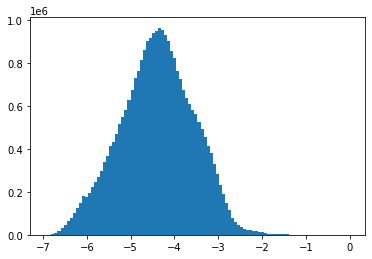

In [ ]:
plt.hist(np.log10(adjacentFiles[adjacentFiles.nonzero()].A[0]), bins=100)

In [ ]:
sorted = np.sort(adjacentFiles.A)
sorted[0, ::-1]

array([0.03544963, 0.01838128, 0.00889201, ..., 0.        , 0.        ,
       0.        ])

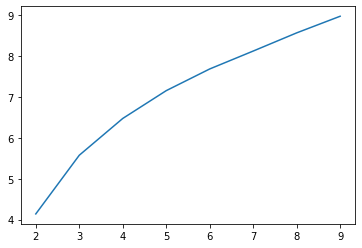

In [ ]:
def getRatios(first, second):
  first *= -1
  second *= -1
  cols = sorted[sorted[:, second] != 0]
  return np.log(cols[:, first] / cols[:, second])
# ratios[ratios == np.inf] = 1e4

# plt.hist(np.log10(ratios), bins=100)
plt.plot(range(2, 10), [getRatios(1, i).mean() * 5 for i in range(2, 10)])

## Graph

### graph-tool

#### Build

In [ ]:
# https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Executing: /tmp/apt-key-gpghome.qW3sxUMAVw/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:8 http://downloads.skewed.de/apt bionic InRelease [7,540 B]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hi

In [ ]:
import graph_tool.all as gt

ModuleNotFoundError: ignored

In [ ]:
def adjacencyToGt(adjacency):
  g = gt.Graph()
  g.add_vertex(adjacency.shape[0])

  ids = adjacency.nonzero()
  weights = adjacency[ids]

  g.edge_properties.weight = g.new_edge_property('double')
  g.add_edge_list(np.transpose(ids))
  g.ep.weight.a = weights
  return g

Creates multigraph where number of edges between two verticies is number of times evidence from the corresponding buckets appear in the same block

In [ ]:
try:
  evGraphM = gt.load_graph(DATA_PATH + '.gt')
except FileNotFoundError:
  evGraphM = gt.Graph(directed=False)
  evGraphM.add_vertex(len(bucketIndexes))

  # Unweighted
  for name, group in tqdm(evClean.groupby(['fileId', 'pocket', 'hat', 'block'])):
    evGraphM.add_edge_list(itertools.combinations(bucketIndexes[group['bucketId']], 2))
  evGraphM.save(DATA_PATH + '.gt')
evGraphM

<Graph object, undirected, with 112310 vertices and 954962 edges, at 0x7f8eb4445950>

Creates weighted graph where weight of edge is number of times evidence from corresponding buckets appear in the same block

In [ ]:
evGraphW = adjacencyToGt(adjacency)
evGraphW.save(DATA_PATH + '_weighted.gt')
evGraphW

<Graph object, directed, with 112310 vertices and 802564 edges, 1 internal edge property, at 0x7f8ecb4d34d0>

Same as weighted graph above, but sum of out edges from every vertex is 1

In [ ]:
evGraphWN = adjacencyToGt(adjacencyN)
evGraphWN.save(DATA_PATH + '_weighted_normalzied.gt')
evGraphWN

<Graph object, directed, with 112310 vertices and 802564 edges, 1 internal edge property, at 0x7f8ecb4d8c90>

In [ ]:
try:
  fileGraph = gt.load_graph(DATA_PATH + '_files.gt')
except FileNotFoundError:
  fileGraph = gt.Graph()

  clippedFiles = adjacentFiles.copy().tolil()
  # Get 100 most closely related files to each file
  clippedFiles[adjacentFiles.A.argsort(axis=0)[0:-100, :]] = 0

  fileGraph = adjacencyToGt(clippedFiles.tocsc())
  # Gives a better distribution for the weights, normalized to 0-1
  fileGraph.ep.weight.a = (np.log(fileGraph.ep.weight.a) + 10) / 10

  fileGraph.save(DATA_PATH + '_files.gt')
fileGraph

<Graph object, directed, with 6914 vertices and 649256 edges, 1 internal edge property, at 0x7f4ea551b390>

#### Analyze

##### Misc

In [ ]:
g = fileGraph
g

<Graph object, directed, with 6914 vertices and 649256 edges, 1 internal edge property, at 0x7fd5589db950>

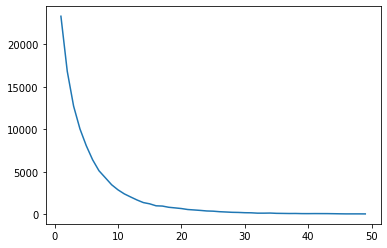

In [ ]:
vals, groups = gt.vertex_hist(evGraphW, 'out', [0, 1])
plt.plot(groups[1:50], np.append(vals, [0])[1:50])

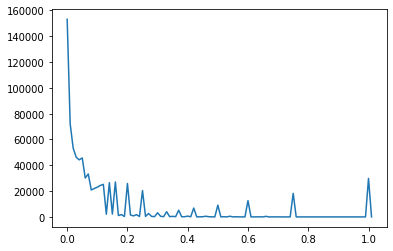

In [ ]:
wVals, wGroups = gt.edge_hist(evGraphWN, evGraphWN.ep.weight, bins=[0, 0.01])
plt.plot(wGroups, np.append(wVals, [0]))

In [ ]:
gt.extract_largest_component(g)

<GraphView object, directed, with 6594 vertices and 646755 edges, 1 internal edge property, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f5b09deda90, at 0x7f5b5a38de50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f5b09deda90, at 0x7f5b09ded710>, False), at 0x7f5b09deda90>

In [ ]:
gt.pseudo_diameter(gt.extract_largest_component(g))

(8.0,
 (<invalid Vertex object at 0x7f5b07efc870>,
  <invalid Vertex object at 0x7f5b07efc750>))

In [ ]:
rank = gt.pagerank(g, weight=g.ep.weight)
# rank = gt.hits(g, g.ep.weight)

In [ ]:
print(pd.Series(rank).sort_values(ascending=False))

1660    0.001682
228     0.001416
3615    0.001403
1328    0.001064
4972    0.001052
          ...   
5049    0.000022
6417    0.000022
5050    0.000022
6415    0.000022
6287    0.000022
Length: 6914, dtype: float64


In [ ]:
showBucketSeries(pd.Series(rank).sort_values(ascending=False), indexes=range(5), iloc=1)

In [ ]:
fClean.loc[fileIds[pd.Series(rank).sort_values(ascending=False).index]]

,createdAt,updatedAt,gid,name,path,status,roundId
id,,,,,,,
14451,2022-08-26 22:19:21.317,2022-09-05 00:14:10.228,TMUL_SRU,Wyoming-Graham-Lever-Aff-Wyoming-Round6,./documents/ndtceda21/Wyoming/GrLe/Wyoming-Gra...,PROCESSED,14278.0
5504,2022-08-19 16:38:23.860,2022-08-20 01:53:36.849,GHG8XXCM,Oil DA File 2 - Michigan7 2021 BFHPR,./documents/openev/2021/UM7/Oil DA File 2 - Mi...,PROCESSED,NaN
13557,2022-08-26 19:01:38.110,2022-09-05 00:18:27.456,1POGZHTY,Rutgers-Ogundare-St-Clair%20Aff-NDT-Round1,./documents/ndtceda21/Rutgers/OgSt/Rutgers-Ogu...,PROCESSED,13192.0
11330,2022-08-26 00:52:45.629,2022-09-05 00:37:37.797,GCS85C5S,George%20Mason-Peake-Lowry-Neg-UMW-Round2,./documents/ndtceda21/GeorgeMason/PeLo/George%...,PROCESSED,10280.0
15123,2022-08-27 00:51:13.684,2022-09-05 00:14:02.781,ALSVO1RU,Berkeley%20Prep-Tirupathi-Zinober-Aff-UT%20Aus...,./documents/hspolicy21/BerkeleyPrep/TiZi/Berke...,PROCESSED,15396.0
...,...,...,...,...,...,...,...
15200,2022-08-27 01:11:26.732,2022-09-05 00:14:03.760,7NGS9ZNF,Bravo-Chanay-Kundu-Neg-Berkeley-Round3,./documents/hspolicy21/Bravo/ChKu/Bravo-Chanay...,PROCESSED,15841.0
16568,2022-08-27 14:27:28.626,2022-09-05 00:50:29.985,8BRRJLTF,Hendrickson-Yedavalli-Duvvuri-Neg-Berkeley%20I...,./documents/hspolicy21/Hendrickson/YeDu/Hendri...,PROCESSED,18958.0
15201,2022-08-27 01:11:39.767,2022-09-05 00:14:03.860,PN6AIQNA,Bravo-Chanay-Kundu-Neg-Berkley-Round2,./documents/hspolicy21/Bravo/ChKu/Bravo-Chanay...,PROCESSED,15842.0


In [ ]:
trust = evGraphW.new_edge_property("double")
trust.a = np.full(len(trust.a), 0.5)

In [ ]:
frBuckets = (evClean[evClean['tag'].str.contains('fracking')]).groupby('bucketId').size().sort_values(ascending=False)
frBIndex = frBuckets.index[0]
frV = evGraphW.vertex(bucketIndexes[frBIndex])
# tt = gt.trust_transitivity(evGraph, trust, source=v)

In [ ]:
pairs = [(bucketIndexes[frBIndex], i) for i in range(evGraphW.num_vertices())]

In [ ]:
%timeit gt.vertex_similarity(evGraphW, eweight=evGraphW.ep.weight, vertex_pairs=pairs)

174 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
similar = pd.Series(gt.vertex_similarity(evGraphW, eweight=evGraphW.ep.weight, vertex_pairs=pairs)).sort_values(ascending=False)
similar

381       1.000000
539       0.447788
14549     0.331570
2861      0.319185
1818      0.304954
            ...   
38673     0.000000
38672     0.000000
38671     0.000000
38670     0.000000
112309    0.000000
Length: 112310, dtype: float64

In [ ]:
showBucketSeries(similar, indexes=range(7))

In [ ]:
# def neighboorCounts(v):
#   return np.array(np.unique(evGraphM.get_out_neighbors(v), return_counts=True)).T

# def neighborhoodCounts(v):
#   counts = {}
#   for id, count in neighboorCounts(v):
#     for nId, nCount in neighboorCounts(id):
#       counts[nId] = counts.get(nId, 0) + count * nCount
#   return pd.Series(counts).sort_values(ascending=False)

# def neighboorhoodWeights(v):
#   weights = {}
#   for id in evGraphW.get_out_neighbors(v):


# %timeit neighborhoodCounts(frV)
# # related = neighborhoodCounts(frV)
# # related

60.4 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.4 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
showBucketSeries(related, indexes=range(7))

In [ ]:
gt.pagerank(evGraphW, weight=evGraphW.ep.weight)

<Graph object, directed, with 6733 vertices and 649256 edges, 1 internal edge property, at 0x7f5b37fdcf10>

##### SBM

'real-exponential'

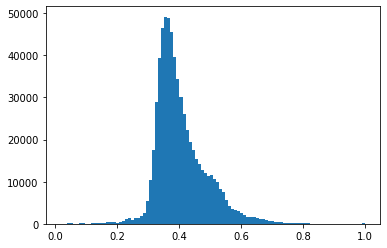

In [ ]:
g = fileGraph
weights = g.ep.weight
weight_distribution = "real-exponential"
plt.hist(weights.a, bins=100)
weight_distribution

###### Block Build

In [ ]:
# Took
state = gt.minimize_blockmodel_dl(g, state_args=dict(recs=[weights], rec_types=[weight_distribution]))
state

<BlockState object with 6914 blocks (201 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 6914 vertices and 649256 edges, 1 internal edge property, at 0x7f4ea551b390>, at 0x7f4e90509550>

In [ ]:
baseEntropy = state.entropy()
baseEntropy

2093636.2860753927

In [ ]:
s1 = state.entropy()
last = s1
for _ in tqdm(range(20)):
  state.multiflip_mcmc_sweep(beta=np.inf, niter=10)
  print(state.entropy() - last)
  last = state.entropy()

print("Total: ")
state.entropy() - s1

  0%|          | 0/20 [00:00<?, ?it/s]

-875.928328151349
-1379.7203172282316
-1036.74501733738
-467.00401337468065
-627.8851704183035
-651.7526414897293
-457.49185818154365
-403.59802789613605
-202.99989617615938
-95.88272992218845
-309.54244291898794
-256.8295963583514
-270.2157701039687
-133.8413505461067
-197.54742866987363
-73.42388634290546
-101.15053488127887
-219.01006249524653
-166.80098321009427
-176.62877631164156
Total: 


-8103.9988320141565

###### Block Analyze

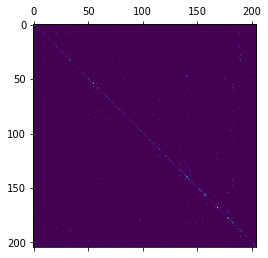

In [ ]:
b = gt.contiguous_map(state.get_blocks())
state = state.copy(b=b)
B = state.get_nonempty_B()

plt.matshow(state.get_matrix().todense()[:B, :B])

In [ ]:
blocks = np.array(list(state.get_blocks()))

In [ ]:
evByFile = evClean.set_index(['fileId', 'id'])
# evByFile.loc[fileIds[blocks == 1]]
fClean.loc[fileIds[blocks == 8]]

,createdAt,updatedAt,gid,name,path,status,roundId
id,,,,,,,
5319,2022-08-19 16:38:16.024,2022-08-20 01:52:42.617,X00E3RNK,Settler Colonialism K - DDI 2021,./documents/openev/2021/DDI/Settler Colonialis...,PROCESSED,NaN
5349,2022-08-19 16:38:16.930,2022-08-20 01:52:46.137,SPYJ6MCD,Tribal Mining Case Neg - DDI 2021 GG,./documents/openev/2021/DDI/Tribal Mining Case...,PROCESSED,NaN
5355,2022-08-19 16:38:17.118,2022-08-20 01:52:31.851,LLRLSVYZ,Environmental Personhood Case Neg - DDI 2021 HL,./documents/openev/2021/DDI/Environmental Pers...,PROCESSED,NaN
5449,2022-08-19 16:38:22.368,2022-08-20 01:52:55.590,M-ZBVEMZ,Settler Enclosure K - MGC 2021,./documents/openev/2021/MGC/Settler Enclosure ...,PROCESSED,NaN
5367,2022-08-19 16:38:17.510,2022-08-20 01:49:38.290,ZULHNI4Z,Environmental Personhood Case Neg - DDI 2021 FJ,./documents/openev/2021/DDI/Environmental Pers...,PROCESSED,NaN
5333,2022-08-19 16:38:16.456,2022-08-20 01:51:27.370,PPVMSXGE,Environmental Personhood Case Neg - DDI 2021 AT,./documents/openev/2021/DDI/Environmental Pers...,PROCESSED,NaN
5410,2022-08-19 16:38:18.833,2022-08-20 01:55:03.862,TTFUG8ZT,Conquest K Supplement - Gonzaga 2021,./documents/openev/2021/GDI/Conquest K Supplem...,PROCESSED,NaN
5543,2022-08-19 16:38:24.719,2022-08-20 01:56:55.270,I3UKVQCC,Settlerism Supplement - Michigan7 2021 BFPSW,./documents/openev/2021/UM7/Settlerism Supplem...,PROCESSED,NaN
5477,2022-08-19 16:38:23.219,2022-08-20 01:55:51.378,DNLCRE6L,Water Colonialism K - Michigan7 2021,./documents/openev/2021/UM7/Water Colonialism ...,PROCESSED,NaN


In [ ]:
frBuckets = (evClean[evClean['tag'].str.contains('fracking')]).groupby('bucketId').size().sort_values(ascending=False)
frI = bucketIndexes[frBuckets.index[0]]
showBucketSeries(buckets[blocks == frI], indexes=range(10))

In [ ]:
d = state.draw(output=f"{DATA_PATH}_blocksF_{datetime.now()}.pdf")

In [ ]:
state.draw(output=f"{DATA_PATH}_blocksF_{datetime.now()}.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4ea551b390, at 0x7f4e85fa5ed0>

In [ ]:
layout = gt.sfdp_layout(gt.extract_largest_component(g), groups=state.get_blocks())
layout

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4ea551b390, at 0x7f4e85fbb3d0>

In [ ]:
gt.graph_draw(gt.extract_largest_component(g), pos=layout, output=f"{DATA_PATH}_blocksF_{datetime.now()}.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4ea551b390, at 0x7f4e853cf250>

In [ ]:
gt.graph_draw(gt.extract_largest_component(g), pos=layout, output=f"{DATA_PATH}_blocksF_{datetime.now()}.pdf")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4eb322d750, at 0x7f4e875009d0>

In [ ]:
gt.graph_draw(gt.extract_largest_component(g), pos=layout, output=f"{DATA_PATH}_blocksF_{datetime.now()}.svg")

cairo.MemoryError: ignored

In [ ]:
# #  Copied from state.draw
# gradient = g.new_ep("double")
# group_vector_property([gradient]
#                       )

###### Nested Block build

In [ ]:
nested_state = gt.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[weights], rec_types=[weight_distribution]))
print(nested_state.entropy())
nested_state

2083396.9862352456


<NestedBlockState object, with base <BlockState object with 6914 blocks (226 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 6914 vertices and 649256 edges, 1 internal edge property, at 0x7ff6c945e550>, at 0x7ff6c646b5d0>, and 14 levels of sizes [(6914, 226), (226, 102), (102, 39), (39, 14), (14, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ff6c646b510>

In [ ]:
s1 = nested_state.entropy()
last = s1
for _ in tqdm(range(20)):
  nested_state.multiflip_mcmc_sweep(beta=np.inf, niter=10)
  print(nested_state.entropy() - last)
  last = nested_state.entropy()

print("Total: ")
nested_state.entropy() - s1

  0%|          | 0/20 [00:00<?, ?it/s]

-4398.612545502838
-3385.9154702406377
-2229.954013719922
-1105.3674165925477
-1160.8766333849635
-818.3903244836256
-1146.4674969969783
-858.8430651954841
-721.0545054152608
-471.8774750442244
-322.0952326825354
-264.6521217180416
-240.17187037295662
-385.96693924744613
-297.1826863803435
-132.9343608720228
-360.8656894455198
-265.7461203993298
-606.2727568401024
-188.99953594990075
Total: 


-19362.24626048468

###### Nested Block Analzye

In [ ]:
nested_state.entropy()

2064034.739974761

In [ ]:
nested_state.print_summary()

l: 0, N: 6914, B: 233
l: 1, N: 233, B: 100
l: 2, N: 100, B: 33
l: 3, N: 33, B: 11
l: 4, N: 11, B: 5
l: 5, N: 5, B: 3
l: 6, N: 3, B: 2
l: 7, N: 2, B: 1
l: 8, N: 1, B: 1


In [ ]:
levels = [np.array(list(gt.contiguous_map(level.get_blocks()))) for level in nested_state.get_levels()]
levelsNc = [np.array(list(level.get_blocks())) for level in nested_state.get_levels()]

In [ ]:
# frBuckets = (evClean[evClean['tag'].str.contains('fracking')]).groupby('bucketId').size().sort_values(ascending=False)
# frI = bucketIndexes[frBuckets.index[0]]
showBucketSeries(buckets[levels[0] == levels[0][2]], indexes=range(10))
buckets[levels[0] == levels[0][0]]
# levels[0:2]

0         428979.0
188       429343.0
271       430132.0
498       428524.0
588       423539.0
768       210057.0
4245      418679.0
4287      428519.0
5851      240670.0
5873      341760.0
5891      101783.0
59763     418706.0
72264     428508.0
72268     428503.0
72279     428512.0
72309     428577.0
72335     428619.0
72343     428553.0
72347     428612.0
77766      47575.0
88457     428703.0
88467     428705.0
88518     428697.0
88529     428700.0
91087     429238.0
91508     429339.0
103651    430091.0
103686    430094.0
104286    430105.0
104654    430067.0
108923    430075.0
110447    430053.0
110458    430079.0
110482    430055.0
110492    430081.0
110493    430084.0
110541    430060.0
110556    430056.0
110592    430057.0
110809    430062.0
110996    430085.0
111066    430088.0
111067    430092.0
111126    430095.0
111403    430096.0
111467    430097.0
111475    430099.0
111523    430109.0
111696    430114.0
111789    430117.0
112129    430120.0
Name: bucketId, dtype: float64

In [ ]:
draw = nested_state.draw(output=f"{DATA_PATH}_nestedblocksF_{datetime.now()}.pdf")

In [ ]:
draw2 = nested_state.draw(output=f"{DATA_PATH}_nestedblocksF_{datetime.now()}.svg")

### igraph



#### Build


In [ ]:
!pip install igraph
!pip install cairocffi
import igraph as ig
import cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=c5ac8c64ff10c0ab2435c613554b4c5d33406bf8109343467cca229ac33362f1
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [ ]:
try:
  iEvGraph = ig.load(DATA_PATH + '_igraph.gml')
except FileNotFoundError:
  iEvGraph = ig.Graph()
  iEvGraph.add_vertices(len(bucketIndexes))

  edges = genEdges()
  iEvGraph.add_edges(edges.keys())
  iEvGraph.es['weight'] = list(edges.values())
  ig.save(iEvGraph, DATA_PATH + '_igraph.gml')
iEvGraph.summary()

'IGRAPH U-W- 112310 691039 -- \n+ attr: id (v), weight (e)'

#### Analyze

In [ ]:
%timeit iEvGraph.neighborhood([frI], order=2)

679 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
pd.Series(iEvGraph.pagerank(weights='weight')).sort_values(ascending=False)

13        0.001898
1324      0.001316
3752      0.001156
343       0.001124
7606      0.001094
            ...   
101911    0.000001
86752     0.000001
101918    0.000001
30024     0.000001
47360     0.000001
Length: 112310, dtype: float64

In [ ]:
showBucketSeries(
    pd.Series(iEvGraph.personalized_pagerank(reset_vertices=[frI], weights='weight')).sort_values(ascending=False)
)

In [ ]:
%timeit pd.Series(iEvGraph.personalized_pagerank(reset_vertices=[teI], weights='weight')).sort_values(ascending=False)

355 ms ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
res = iEvGraph.community_label_propagation(weights='weight')
res